In [1]:
import pyvinecopulib as pv
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from Ratio import *
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF as fit_ecdf
from scipy.special import logsumexp

def emp_cdf(v, u):
    """ evaluate the empirical copula at points v using the samples u"""
    # cdf is evaluated at points v, v has to be a MxD vector in [0,1]^D, cdf is evaluated at these points
    # u are samples from model NxD vector in [0,1]^D, u should be very large
    # larger u will lead to better estimation of the empirical copula but slows down computation
    cdf_vals = np.empty(shape=(len(v)))
    for i in range(v.shape[0]):
        cdf_vals[i] = np.sum(np.all(u<=v[[i],:], axis=1))
    return cdf_vals/len(u)

In [2]:
def sample(cop_name, nsamples, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    elif cop_name == "mixture":
        combination = params["combination"]
        copulas = [pv.Bicop(family=pv.BicopFamily[comp["type"]], parameters=comp["theta"]) for comp in combination]
        weights = [comp["weight"] for comp in combination]
        copula = pv.MixtureBicop(copulas, weights)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    return copula.simulate(nsamples)

def log_likelihood(cop_name, u1, u2, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    data = np.column_stack((u1, u2))
    return copula.loglik(data)

# Example usage:
params_gaussian = {"corrMatrix": [0.1]}
samples = sample("gaussian", 500, params_gaussian)
u1, u2 = samples[:, 0], samples[:, 1]
log_likelihood_value = log_likelihood("gaussian", u1, u2, params_gaussian)
print(log_likelihood_value)

1.884827262949023


In [3]:
N_TRAIN = 1000
N_TEST = 5000
N_ROUNDS = 25
np.random.seed(990109)

sims_runs_all = []
log_likelihoods_runs_all = []

for round in tqdm(range(N_ROUNDS)):
    # Generate data

    # Student-t
    corrMatrix = np.random.uniform(0.5,0.95)
    nu = np.random.uniform(2,10)

    params_student = {"corrMatrix": corrMatrix, "nu": nu}
    samples_student = sample("student", N_TRAIN + N_TEST, params_student)
    u1_student, u2_student = samples_student[:, 0], samples_student[:, 1]
    log_likelihood_student = log_likelihood("student", u1_student[N_TRAIN:], u2_student[N_TRAIN:], params_student)

    # Clayton
    theta = 2
    params_clayton = {"theta": [theta]}
    samples_clayton = sample("clayton", N_TRAIN + N_TEST, params_clayton)
    u1_clayton, u2_clayton = samples_clayton[:, 0], samples_clayton[:, 1]
    log_likelihood_clayton = log_likelihood("clayton", u1_clayton[N_TRAIN:], u2_clayton[N_TRAIN:], params_clayton)

    # Gumbel
    theta = 2
    params_gumbel = {"theta": [theta]}
    samples_gumbel = sample("gumbel", N_TRAIN + N_TEST, params_gumbel)
    u1_gumbel, u2_gumbel = samples_gumbel[:, 0], samples_gumbel[:, 1]
    log_likelihood_gumbel = log_likelihood("gumbel", u1_gumbel[N_TRAIN:], u2_gumbel[N_TRAIN:], params_gumbel)

    # Mixture of 2 gaussians (using scipy.stats: first mixture on gaussian z-space, then transform to copula u-space)
    '''
    # My mixture 
    means = [[np.random.uniform(-5, 5), np.random.uniform(-5, 5)]for _ in range(2)]
    covs = [np.random.uniform(-0.95, 0.95), np.random.uniform(-0.95, 0.95)]
    multipliers = [np.random.uniform(0.8,1.2), np.random.uniform(0.8,1.2)]
    z = np.concatenate(
        [scs.multivariate_normal.rvs(
        mean=means[i], cov=multipliers[i]*np.array([[1,covs[i]],[covs[i],1]]
        ), size=int((N_TRAIN + N_TEST)/2)) for i in range(2)])
    u_1_mix = 0.5*(scs.norm(loc=means[0][0], scale=multipliers[0]).cdf(z[:,0]) + scs.norm(loc=means[1][0], scale=multipliers[1]).cdf(z[:,0]))
    u_2_mix = 0.5*(scs.norm(loc=means[0][1], scale=multipliers[0]).cdf(z[:,1]) + scs.norm(loc=means[1][1], scale=multipliers[1]).cdf(z[:,1]))
    u_1_mix = u_1_mix[np.random.permutation(N_TRAIN + N_TEST)]
    u_2_mix = u_2_mix[np.random.permutation(N_TRAIN + N_TEST)]
    log_likelihood_top = scs.multivariate_normal.logpdf(z[N_TRAIN:], mean=means[0], cov=multipliers[0]*np.array([[1,covs[0]],[covs[0],1]])).sum() + scs.multivariate_normal.logpdf(z[N_TRAIN:], mean=means[1], cov=multipliers[1]*np.array([[1,covs[1]],[covs[1],1]]).sum()) 
    log_likelihood_bottom = '''
    # ----------------------------- IGC mixture -----------------------------
    mu_1 = np.random.uniform(-5,5,2)
    sigma_1 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)
    
    mu_2 = np.random.uniform(-5,5,2)
    sigma_2 = (np.eye(2)+np.eye(2)[[1,0],:]*np.random.uniform(-0.95,0.95,1))*np.random.uniform(0.8,1.2)

    x1 = np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TRAIN+N_TEST)
    x2 = np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TRAIN+N_TEST)

    X = np.vstack([x1,x2])
    np.random.shuffle(X)
    cdf_1 = fit_ecdf(X[:,0])
    cdf_2 = fit_ecdf(X[:,1])
    U = np.column_stack((cdf_1(X[:,0]), cdf_2(X[:,1])))
    
    X_train = np.vstack([np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TRAIN),
                         np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TRAIN)])
    np.random.shuffle(X_train)
    U_train = np.column_stack([cdf_1(X_train[:,0]), cdf_2(X_train[:,1])])

    X_test = np.vstack([np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=N_TEST),
                        np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=N_TEST)])
    np.random.shuffle(X_test)
    U_test = np.column_stack([cdf_1(X_test[:,0]), cdf_2(X_test[:,1])])
    
    u_1_mix = np.concatenate([U_train[:,0], U_test[:,0]])
    u_2_mix = np.concatenate([U_train[:,1], U_test[:,1]])  
    # ----------------------------- IGC mixture -----------------------------



    # append to list
    sims_runs_all.append([[u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]])
    log_likelihoods_runs_all.append([log_likelihood_student, log_likelihood_clayton, log_likelihood_gumbel, _])

100%|██████████| 25/25 [00:01<00:00, 19.27it/s]


KeyboardInterrupt: 

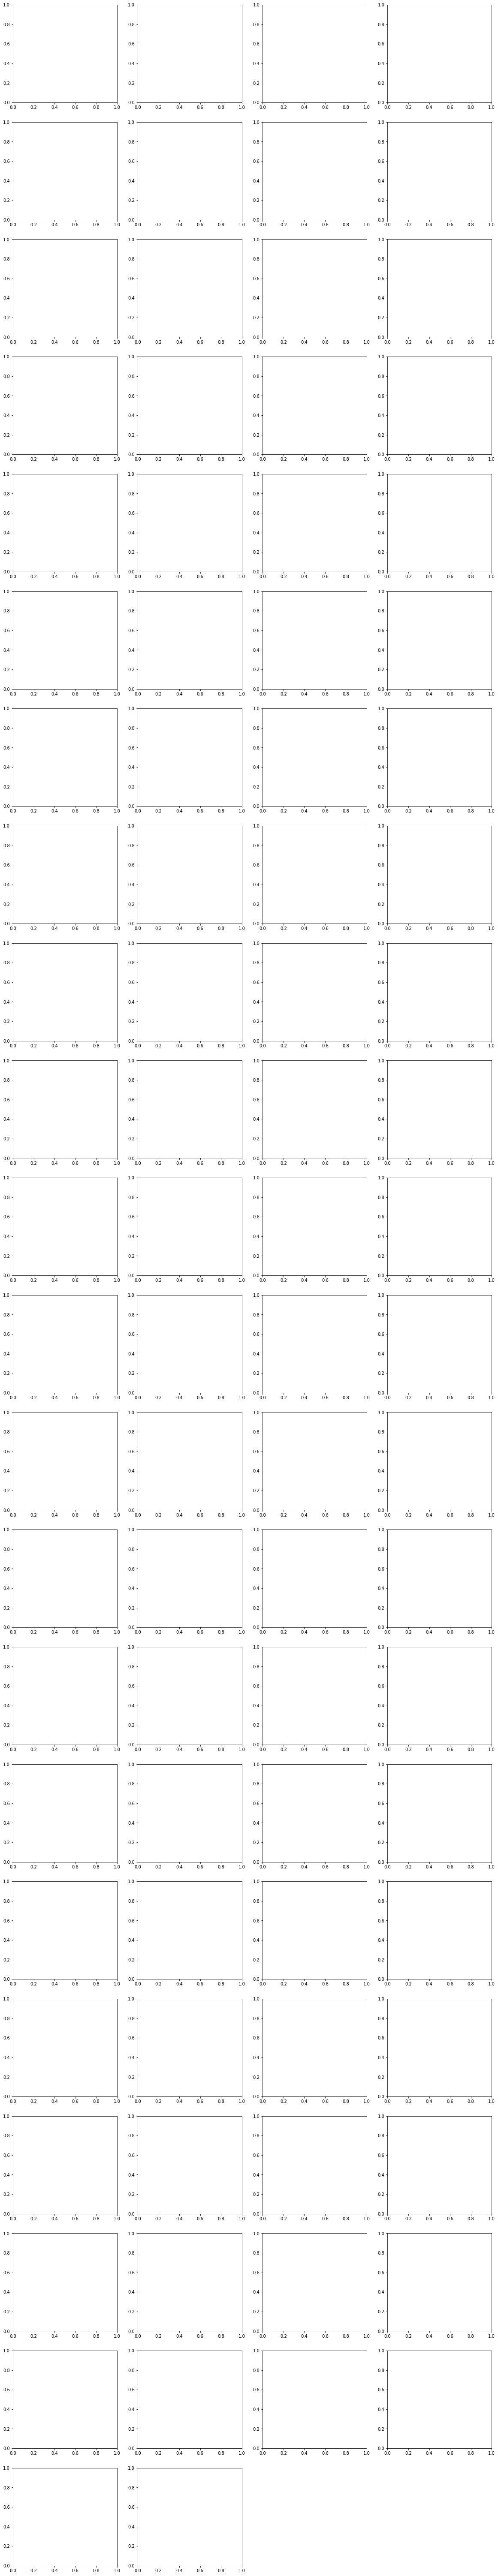

In [4]:
import matplotlib.pyplot as plt

# Assuming sims_runs_all is already populated with the samples

fig, axes = plt.subplots(24, 4, figsize=(20, 120))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

for i in range(24):
    for j in range(4):
        ax = axes[i * 4 + j]
        u1, u2 = sims_runs_all[i][j]
        ax.scatter(u1, u2, s=1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'Round {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

In [17]:
ratios = []

for r,run in tqdm(enumerate(sims_runs_all[:5])):
    # run = [u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]
    for u,u1_u2 in enumerate(run):
        # u1_u2 = [u1, u2]
        z1,z2 = scs.norm.ppf(u1_u2[0][:N_TRAIN]),scs.norm.ppf(u1_u2[1][:N_TRAIN])
        p_data = np.column_stack((z1,z2))
        p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
        q_data = np.random.randn(50000,2)
        # Fit Ratio copula
        ratio = Ratio(h_dim=100, in_dim=2, h_layers=2, normalising_cst=True)
        #optimizer = torch.optim.Adam(ratio.parameters())
        optimizer = torch.optim.Adam(
            [{'params': [param for param in ratio.parameters() if param is not ratio.c]},
            {'params': [ratio.c], 'lr': 0.01}]  # Adjust the learning rate for ratio.c here
        )
        #if ratio.normalising_cst:
        #    optimizer.add_param_group({'params': ratio.c})

        for epoch in (range(501)):
            optimizer.zero_grad()
            r_p = ratio(torch.tensor(p_data).float())
            r_q = ratio(torch.tensor(np.random.randn(p_data.shape[0],2)).float())
            #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
            loss = loss_nce(r_p, r_q, p_data.shape[0], q_data.shape[0])
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0 and epoch > 0:
                with torch.no_grad():
                    if True:#epoch==500:# check the value and gradient of the normalising constant
                        print(f'Epoch {epoch}, normalising constant {ratio.c.item()}', ratio.c.grad.item())
                    #check if loss is not a number
                    if torch.isnan(loss):
                        print(r,u,'NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                    #print(f'Epoch {epoch}, loss {loss.item()}')
        print('run',r,'cop_u',u,'DONE')
        ratios.append(ratio)


0it [00:00, ?it/s]

Epoch 100, normalising constant 1.113818645477295 0.12203550338745117
Epoch 200, normalising constant 1.1023160219192505 -0.009454488754272461
Epoch 300, normalising constant 1.0905488729476929 0.008556842803955078
Epoch 400, normalising constant 1.0875604152679443 -0.00320512056350708
Epoch 500, normalising constant 1.0790902376174927 -0.06931871175765991
run 0 cop_u 0 DONE
Epoch 100, normalising constant 1.0136610269546509 0.022969186305999756
Epoch 200, normalising constant 1.0069371461868286 -0.11357003450393677
Epoch 300, normalising constant 1.0001003742218018 -0.011883080005645752
Epoch 400, normalising constant 1.0033208131790161 -0.02457338571548462
Epoch 500, normalising constant 1.0039325952529907 0.0885087251663208
run 0 cop_u 1 DONE
Epoch 100, normalising constant 0.9933518171310425 -0.0659327507019043
Epoch 200, normalising constant 1.0011703968048096 -0.028300344944000244
Epoch 300, normalising constant 0.996171772480011 0.018376648426055908
Epoch 400, normalising consta

1it [00:18, 18.43s/it]

Epoch 500, normalising constant 1.0386024713516235 -0.052127838134765625
run 0 cop_u 3 DONE
Epoch 100, normalising constant 1.0481703281402588 0.015362262725830078
Epoch 200, normalising constant 1.0460015535354614 0.04961705207824707
Epoch 300, normalising constant 1.0246825218200684 -0.0580751895904541
Epoch 400, normalising constant 1.01156747341156 -0.05692875385284424
Epoch 500, normalising constant 1.0041730403900146 -0.00025403499603271484
run 1 cop_u 0 DONE
Epoch 100, normalising constant 0.9745578169822693 -0.05138289928436279
Epoch 200, normalising constant 0.9572428464889526 0.05104619264602661
Epoch 300, normalising constant 0.9499403238296509 -0.0023097991943359375
Epoch 400, normalising constant 0.9385016560554504 -0.006398797035217285
Epoch 500, normalising constant 0.9315652847290039 -0.051793813705444336
run 1 cop_u 1 DONE
Epoch 100, normalising constant 1.0603697299957275 -0.009301722049713135
Epoch 200, normalising constant 1.0754761695861816 0.05440276861190796
Epoc

2it [00:35, 17.53s/it]

Epoch 500, normalising constant 1.1232246160507202 -0.0027651190757751465
run 1 cop_u 3 DONE
Epoch 100, normalising constant 1.0863070487976074 -0.05759096145629883
Epoch 200, normalising constant 1.0928303003311157 0.04514509439468384
Epoch 300, normalising constant 1.09419584274292 0.05171394348144531
Epoch 400, normalising constant 1.0912355184555054 -0.09980553388595581
Epoch 500, normalising constant 1.10136079788208 -0.0035753250122070312
run 2 cop_u 0 DONE
Epoch 100, normalising constant 0.9945399165153503 0.038455426692962646
Epoch 200, normalising constant 0.997515082359314 -0.03644704818725586
Epoch 300, normalising constant 1.0053949356079102 0.10935318470001221
Epoch 400, normalising constant 0.9944071173667908 -0.04614502191543579
Epoch 500, normalising constant 0.9956387877464294 0.08012211322784424
run 2 cop_u 1 DONE
Epoch 100, normalising constant 1.079228401184082 -0.02085214853286743
Epoch 200, normalising constant 1.0879640579223633 0.030327022075653076
Epoch 300, no

3it [00:52, 17.16s/it]

Epoch 500, normalising constant 0.932830810546875 0.07607614994049072
run 2 cop_u 3 DONE
Epoch 100, normalising constant 1.0850268602371216 -0.03023707866668701
Epoch 200, normalising constant 1.0849698781967163 -0.04960060119628906
Epoch 300, normalising constant 1.0899291038513184 -0.0210951566696167
Epoch 400, normalising constant 1.084818720817566 0.004203081130981445
Epoch 500, normalising constant 1.0873454809188843 -0.021837472915649414
run 3 cop_u 0 DONE
Epoch 100, normalising constant 1.0897269248962402 0.08896291255950928
Epoch 200, normalising constant 1.0889867544174194 0.017533302307128906
Epoch 300, normalising constant 1.0837149620056152 0.029598593711853027
Epoch 400, normalising constant 1.0773950815200806 0.0006606578826904297
Epoch 500, normalising constant 1.0652031898498535 -0.05168956518173218
run 3 cop_u 1 DONE
Epoch 100, normalising constant 1.0581477880477905 0.011606931686401367
Epoch 200, normalising constant 1.0537370443344116 -0.01081240177154541
Epoch 300,

4it [01:08, 16.89s/it]

Epoch 500, normalising constant 1.0338449478149414 -0.06891494989395142
run 3 cop_u 3 DONE
Epoch 100, normalising constant 0.9965144395828247 -0.0398787260055542
Epoch 200, normalising constant 1.001713514328003 0.13725650310516357
Epoch 300, normalising constant 1.0009490251541138 0.12651634216308594
Epoch 400, normalising constant 0.9987191557884216 -0.010817468166351318
Epoch 500, normalising constant 0.9930495619773865 0.1475098729133606
run 4 cop_u 0 DONE
Epoch 100, normalising constant 1.0994625091552734 -0.08169543743133545
Epoch 200, normalising constant 1.069254994392395 -0.03648954629898071
Epoch 300, normalising constant 1.0574147701263428 -0.058136820793151855
Epoch 400, normalising constant 1.047724962234497 0.008659005165100098
Epoch 500, normalising constant 1.0459623336791992 0.008834302425384521
run 4 cop_u 1 DONE
Epoch 100, normalising constant 0.9754496812820435 -0.04446673393249512
Epoch 200, normalising constant 0.970755398273468 -0.03712660074234009
Epoch 300, nor

5it [01:26, 17.38s/it]

Epoch 500, normalising constant 1.0440559387207031 0.13683348894119263
run 4 cop_u 3 DONE


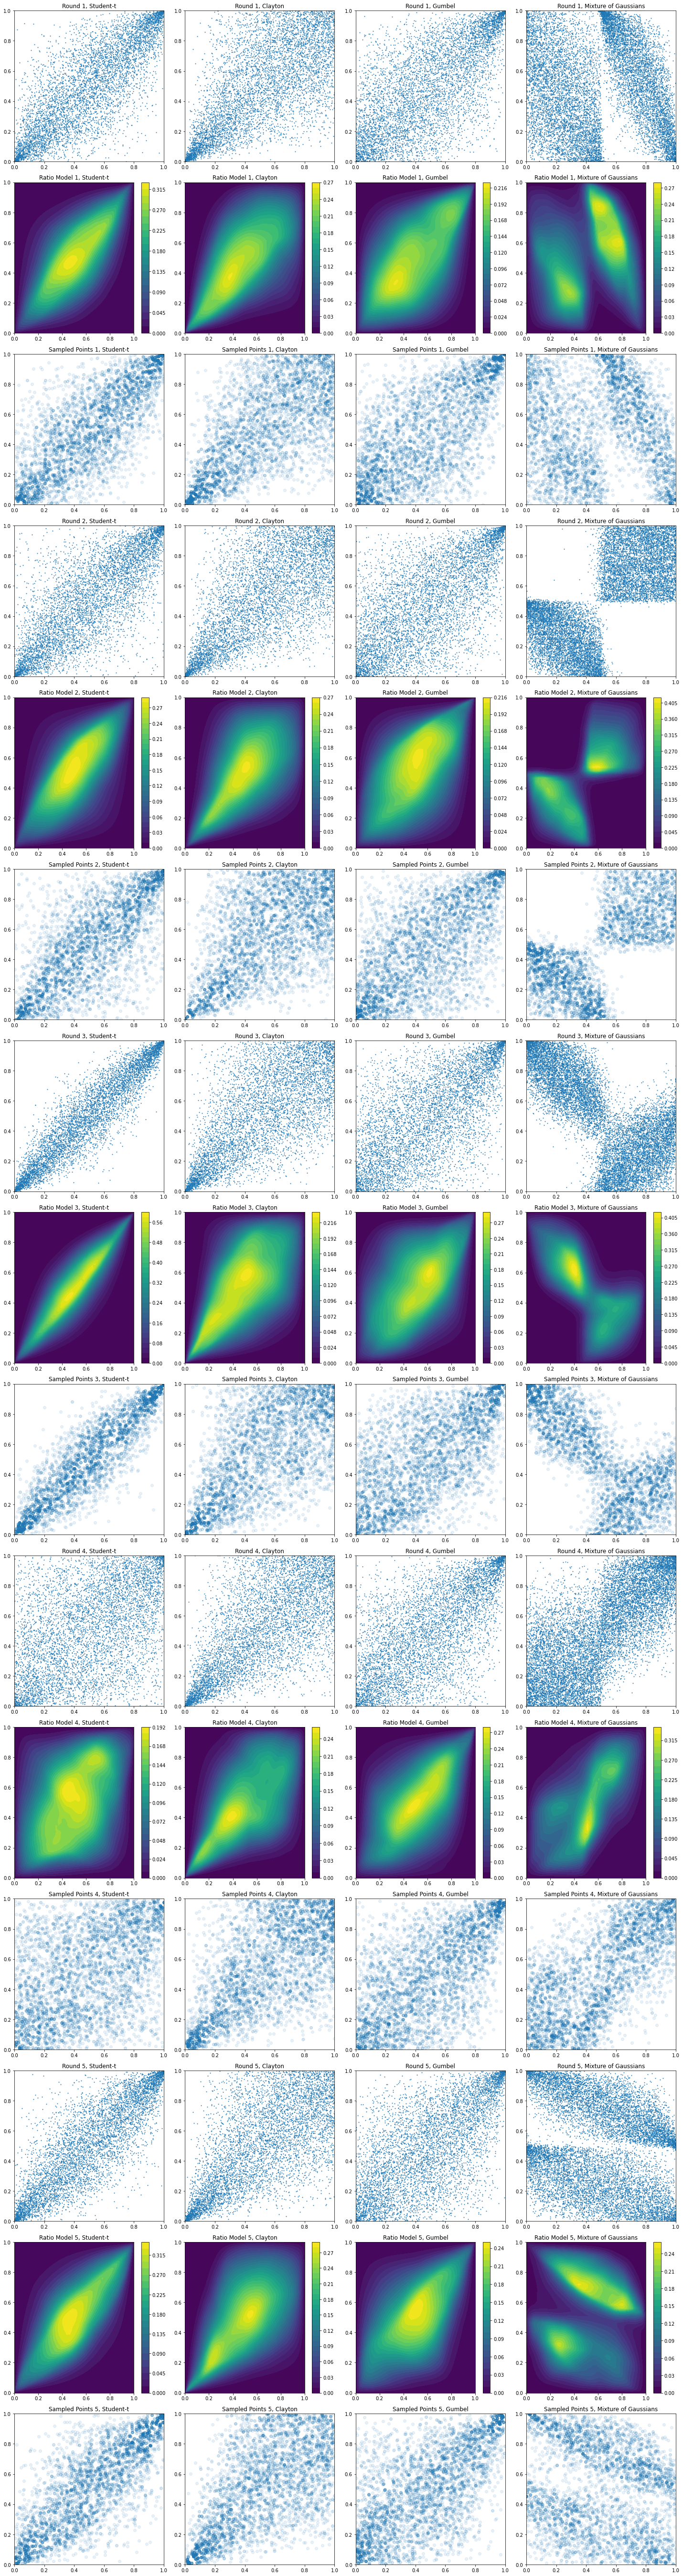

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats
from tqdm import tqdm
from scipy.special import logsumexp

def sample_ratio(ratio, n):
    '''
    Sample from the ratio copula with Sampling Importance Resampling.
    '''
    z = np.random.randn(n, 2)
    r_log = np.log(ratio(torch.tensor(z).float()).detach().numpy())
    sims = np.random.choice(np.arange(n), size=n, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
    return scipy.stats.norm.cdf(z[sims])

fig, axes = plt.subplots(int(75/5), 4, figsize=(20, int(375/5)))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

# Plot the true samples, the ratio models, and the sampled points
for i in range(5):
    for j in range(4):
        # Plot the true samples
        ax_true = axes[i * 12 + j]
        u1, u2 = sims_runs_all[i][j]
        ax_true.scatter(u1, u2, s=1)
        ax_true.set_xlim(0, 1)
        ax_true.set_ylim(0, 1)
        ax_true.set_title(f'Round {i+1}, {sample_types[j]}')

        # Plot the ratio models
        ax_ratio = axes[i * 12 + 4 + j]
        
        # Create a grid for plotting
        x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
        z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
        gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

        # Get the ratio
        r = ratios[i * 4 + j](z.float()).detach().numpy()
        Z = (r.reshape(100, 100)) * gauss
        contour = ax_ratio.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
        ax_ratio.set_xlim(0, 1)
        ax_ratio.set_ylim(0, 1)
        ax_ratio.set_title(f'Ratio Model {i+1}, {sample_types[j]}')
        fig.colorbar(contour, ax=ax_ratio)
        
        # Plot the sampled points
        ax_sampled = axes[i * 12 + 8 + j]
        samples_test = sample_ratio(ratios[i * 4 + j], 5000)
        ax_sampled.scatter(samples_test[:, 0], samples_test[:, 1], alpha=0.1)
        ax_sampled.set_xlim(0, 1)
        ax_sampled.set_ylim(0, 1)
        ax_sampled.set_title(f'Sampled Points {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

In [21]:
# HMC sampling from the ratio copula
from pyhmc import hmc
def sample_ratio(ratio_model, n,hmc_runs=5,burn_in_n=1000,bimodal_hmc=False):
    def log_r_times_gauss(x):
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        fun = torch.log(ratio_model(x_tensor))+torch.distributions.Normal(0,1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad
        return np.array(fun.item(),dtype=np.float64), np.array(grad_wrt_x.detach().numpy(),dtype=np.float64)

    def sample_ratio_IS(ratio, n_prop, n_out):
        '''
        Sample from the ratio copula with Sampling Importance Resampling.
        '''
        z = np.random.randn(n_prop, 2)
        r_log = np.log(ratio(torch.tensor(z).float()).detach().numpy())+torch.distributions.Normal(0,1).log_prob(torch.tensor(z).float()).sum(1).detach().numpy().reshape(-1,1)
        sims = np.random.choice(np.arange(n_prop), size=n_out, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
        return scipy.stats.norm.cdf(z[sims])

    samples = []
    log_pdf_samples = []
    for hmc_run in range(hmc_runs): # multiple runs to avoid local modes
        # pcik a starting point with IS to be closer to equilibrium, so shorter burn_in
        start_x = sample_ratio_IS(ratio_model, 100, 1)
        if bimodal_hmc: # run HMC from both sides of the mode via reflection of x_0
            samples1 = hmc(log_r_times_gauss,
                        x0=start_x[0],
                        n_samples=int(n/2),
                        return_logp= True,
                        n_burn = burn_in_n)
            samples2 = hmc(log_r_times_gauss,
                    x0=-start_x[0],
                    n_samples=int(n/2),
                    return_logp= True,
                    n_burn = burn_in_n)
            samples.append(np.concatenate([samples1[0],samples2[0]]))
            log_pdf_samples.append(np.concatenate([samples1[1],samples2[1]]))
        else: 
            samples1 = hmc(log_r_times_gauss,
                        x0=start_x[0],
                        n_samples=n,
                        return_logp= True,
                        n_burn = burn_in_n)
            samples.append(samples1[0])
            log_pdf_samples.append(samples1[1])

        print('run',hmc_run,'DONE')
    # combine all runs
    samples = np.concatenate(samples)
    log_pdf_samples = np.concatenate(log_pdf_samples)
    return samples, log_pdf_samples

n_runs = 100
n_sims = 100
samples, log_pdf_samples = sample_ratio(ratios[16], n_sims, hmc_runs=n_runs, burn_in_n=10,bimodal_hmc=True)

run 0 DONE
run 1 DONE
run 2 DONE
run 3 DONE
run 4 DONE
run 5 DONE
run 6 DONE
run 7 DONE
run 8 DONE
run 9 DONE
run 10 DONE
run 11 DONE
run 12 DONE
run 13 DONE
run 14 DONE
run 15 DONE
run 16 DONE
run 17 DONE
run 18 DONE
run 19 DONE
run 20 DONE
run 21 DONE
run 22 DONE
run 23 DONE
run 24 DONE
run 25 DONE
run 26 DONE
run 27 DONE
run 28 DONE
run 29 DONE
run 30 DONE
run 31 DONE
run 32 DONE
run 33 DONE
run 34 DONE
run 35 DONE
run 36 DONE
run 37 DONE
run 38 DONE
run 39 DONE
run 40 DONE
run 41 DONE
run 42 DONE
run 43 DONE
run 44 DONE
run 45 DONE
run 46 DONE
run 47 DONE
run 48 DONE
run 49 DONE
run 50 DONE
run 51 DONE
run 52 DONE
run 53 DONE
run 54 DONE
run 55 DONE
run 56 DONE
run 57 DONE
run 58 DONE
run 59 DONE
run 60 DONE
run 61 DONE
run 62 DONE
run 63 DONE
run 64 DONE
run 65 DONE
run 66 DONE
run 67 DONE
run 68 DONE
run 69 DONE
run 70 DONE
run 71 DONE
run 72 DONE
run 73 DONE
run 74 DONE
run 75 DONE
run 76 DONE
run 77 DONE
run 78 DONE
run 79 DONE
run 80 DONE
run 81 DONE
run 82 DONE
run 83 DONE
ru

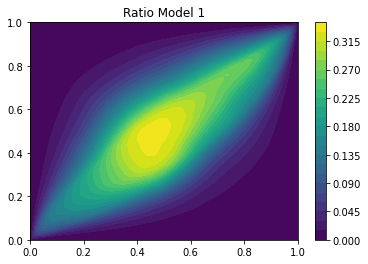

In [22]:
# contourf of ratios[0]

x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Get the ratio
r = ratios[16](z.float()).detach().numpy()
Z = (r.reshape(100, 100)) * gauss
plt.contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Ratio Model 1')  
plt.colorbar()
plt.show()

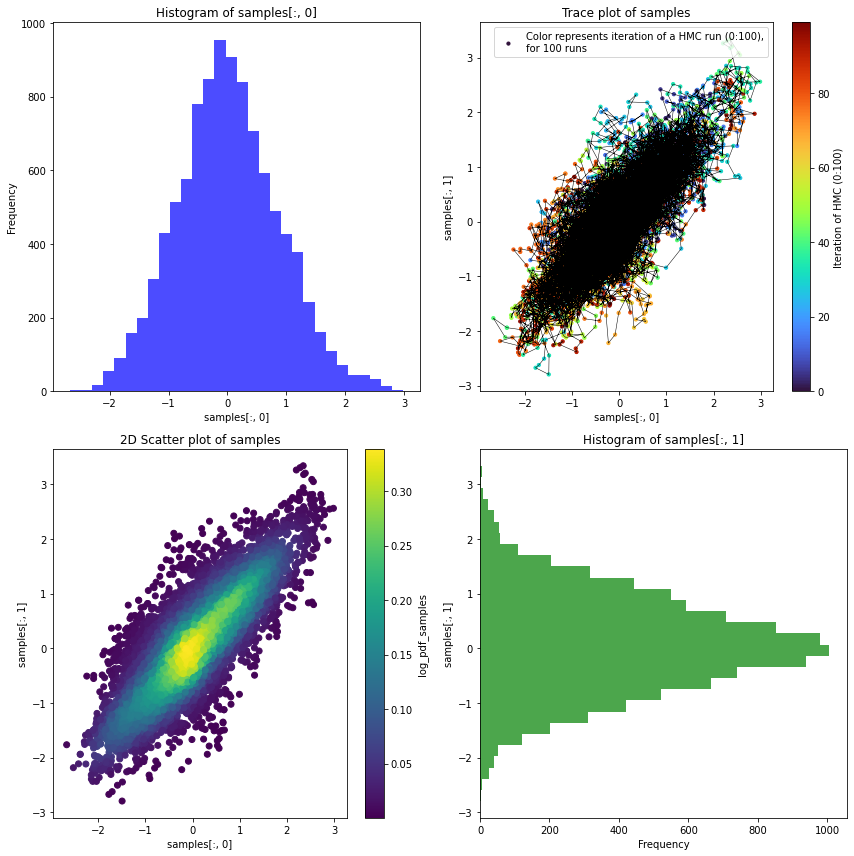

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Subplot [0,0]: Histogram of samples[:, 0]
axs[0, 0].hist(samples[:, 0], bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Histogram of samples[:, 0]')
axs[0, 0].set_xlabel('samples[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal')
axs[1, 1].set_title('Histogram of samples[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples[:, 0], samples[:, 1], c=np.exp(log_pdf_samples), cmap='viridis', marker='o')
axs[1, 0].set_title('2D Scatter plot of samples')
axs[1, 0].set_xlabel('samples[:, 0]')
axs[1, 0].set_ylabel('samples[:, 1]')
fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples
color_array = np.tile(np.arange(n_sims), n_runs)
sc_ = axs[0, 1].scatter(samples[:, 0], samples[:, 1], c=color_array, cmap='turbo', s=10)  # Set size of points
axs[0, 1].scatter(samples[:, 0], samples[:, 1], c=color_array, cmap='turbo', alpha=0.1, s=10)  # Set size of points
axs[0, 1].plot(samples[:, 0], samples[:, 1], color='black', linewidth=0.5)
axs[0, 1].set_title('Trace plot of samples')
axs[0, 1].set_xlabel('samples[:, 0]')
axs[0, 1].set_ylabel('samples[:, 1]')
fig.colorbar(sc_, ax=axs[0, 1], label=f'Iteration of HMC (0:{n_sims})')
legend_label = f'Color represents iteration of a HMC run (0:{n_sims}),\nfor {n_runs} runs'
axs[0, 1].legend([legend_label], loc='upper right')


plt.tight_layout()
plt.show()

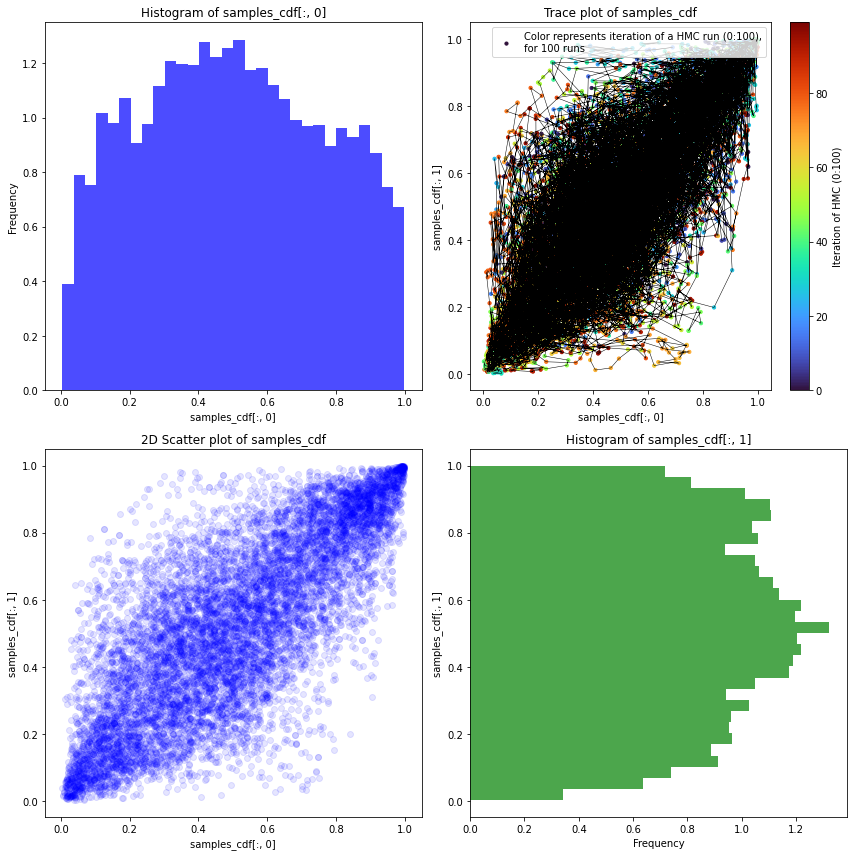

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming samples is a 2D array with shape (n_samples, 2)
# and log_pdf_samples is a 1D array with shape (n_samples,)

# Transform samples using the CDF
samples_cdf = scs.norm.cdf(samples)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Subplot [0,0]: Histogram of samples_cdf[:, 0]
axs[0, 0].hist(samples_cdf[:, 0], bins=30, color='blue', alpha=0.7,density=True)
axs[0, 0].set_title('Histogram of samples_cdf[:, 0]')
axs[0, 0].set_xlabel('samples_cdf[:, 0]')
axs[0, 0].set_ylabel('Frequency')

# Subplot [1,1]: Histogram of samples_cdf[:, 1] rotated 90 degrees clockwise
axs[1, 1].hist(samples_cdf[:, 1], bins=30, color='green', alpha=0.7, orientation='horizontal',density=True)
axs[1, 1].set_title('Histogram of samples_cdf[:, 1]')
axs[1, 1].set_xlabel('Frequency')
axs[1, 1].set_ylabel('samples_cdf[:, 1]')

# Subplot [1,0]: 2D scatter plot of samples_cdf with colors based on log_pdf_samples
sc = axs[1, 0].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c='blue',alpha=0.1, marker='o')
axs[1, 0].set_title('2D Scatter plot of samples_cdf')
axs[1, 0].set_xlabel('samples_cdf[:, 0]')
axs[1, 0].set_ylabel('samples_cdf[:, 1]')
#fig.colorbar(sc, ax=axs[1, 0], label='log_pdf_samples')

# Subplot [0,1]: Trace plot of samples_cdf
color_array = np.tile(np.arange(n_sims), n_runs)
sc_ = axs[0, 1].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c=color_array, cmap='turbo', s=10)  # Set size of points
axs[0, 1].scatter(samples_cdf[:, 0], samples_cdf[:, 1], c=color_array, cmap='turbo', alpha=0.1, s=10)  # Set size of points
axs[0, 1].plot(samples_cdf[:, 0], samples_cdf[:, 1], color='black', linewidth=0.5)
axs[0, 1].set_title('Trace plot of samples_cdf')
axs[0, 1].set_xlabel('samples_cdf[:, 0]')
axs[0, 1].set_ylabel('samples_cdf[:, 1]')
fig.colorbar(sc_, ax=axs[0, 1], label=f'Iteration of HMC (0:{n_sims})')
legend_label = f'Color represents iteration of a HMC run (0:{n_sims}),\nfor {n_runs} runs'
axs[0, 1].legend([legend_label], loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
ratios[16].c

Parameter containing:
tensor(0.9930, requires_grad=True)

In [28]:
# does it integrate to 1?
x = np.linspace(1e-10,1-(1e-10),100)
y = np.linspace(1e-10,1-(1e-10),100)
x_ = np.linspace(scs.norm.ppf(1e-10),scs.norm.ppf(1-1e-10),100)
y_ = np.linspace(scs.norm.ppf(1e-10),scs.norm.ppf(1-1e-10),100)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
for i in tqdm(range(100)):
    for j in range(100):
        #print(torch.tensor([scs.norm.ppf(x[i]),scs.norm.ppf(y[j])]).float()-torch.tensor([x_[i],y_[j]]).float())
        Z[i,j] = ratios[-1](torch.tensor([scs.norm.ppf(X[i,j]),scs.norm.ppf(Y[i,j])]).float()).detach().numpy()

print(np.trapz(np.trapz(Z,x),y))

100%|██████████| 100/100 [00:04<00:00, 22.60it/s]

1.0714087520856754


In [14]:
from scipy.integrate import simps
import numpy as np
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 30)
z = np.cos(x[:,None])**4 + np.sin(y)**2
simps(simps(z, y), x)

0.8513409974325956

In [32]:
# Create a grid of points from -10 to 10
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Evaluate ratios[16] at each point on the grid
for i in tqdm(range(100)):
    for j in range(100):
        Z[i, j] = ratios[16](torch.tensor([X[i, j], Y[i, j]]).float()).detach().numpy()

# Integrate using numerical integration
integral = np.trapz(np.trapz(Z, x), y)
print(f"Integral over the grid from -10 to 10: {integral}")

100%|██████████| 100/100 [00:01<00:00, 51.50it/s]

Integral over the grid from -10 to 10: 5.053660041226632


In [38]:
ratios[16](torch.tensor(samples).float()).mean()

tensor(2.6351, grad_fn=<MeanBackward0>)

In [43]:
samples_gauss.shape

torch.Size([5000, 2])

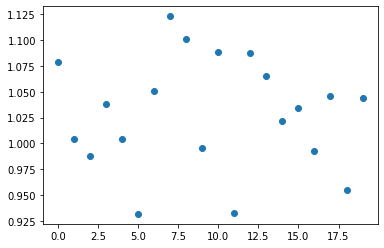

In [140]:
plt.plot([ratios[k].c.item() for k in range(len(ratios))],'o')

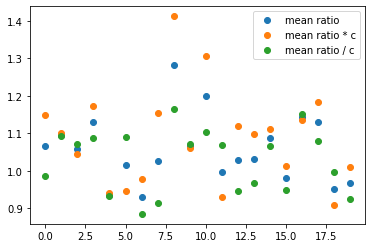

In [138]:
prop_scale = 0.9
r_idx = 6
out = []
for r_idx in range(len(ratios)):
    samples_gauss = torch.normal(mean=0., std=prop_scale, size=(10000, 2))
    r_gauss_1_2 = torch.distributions.Normal(loc=0., scale=1.).log_prob(samples_gauss).sum(1).detach().numpy()-torch.distributions.Normal(loc=0., scale=prop_scale).log_prob(samples_gauss).sum(1).detach().numpy()
    r_gauss = ratios[r_idx](samples_gauss).detach().numpy()/np.exp(r_gauss_1_2) 
    out.append(   [ r_gauss.mean(),r_gauss.mean()*ratios[r_idx].c.item(),r_gauss.mean()/ratios[r_idx].c.item()])

plt.plot([out[i][0] for i in range(len(ratios))],'o',label='mean ratio')
plt.plot([out[i][1] for i in range(len(ratios))],'o',label='mean ratio * c')
plt.plot([out[i][2] for i in range(len(ratios))],'o',label='mean ratio / c')
plt.legend()

In [51]:
samples_gauss = torch.randn(5000, 2)
r_gauss = ratios[16](samples_gauss).detach().numpy()

# Compute the integral using np.trapz
# First integrate along the second dimension (axis=1)
integral_first_pass = np.trapz(r_gauss, samples_gauss[:, 1], axis=1)

# Then integrate the result along the first dimension (axis=0)
integral_gauss = np.trapz(integral_first_pass, samples_gauss[:, 0])
print(f"Integral over the grid from -10 to 10 for Gaussian samples: {integral_gauss}")

ValueError: operands could not be broadcast together with shapes (1,4999) (5000,0) 

In [143]:
import numpy as np
import scipy.stats as scs
from scipy.integrate import simps
import torch

# Define the grid
x = np.linspace(1e-10, 1-1e-10, 100)
y = np.linspace(1e-10, 1-1e-10, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the function over the grid
Z = np.zeros_like(X)
for i in tqdm(range(len(x))):
    for j in range(len(y)):
        x_ = scs.norm.ppf(X[i, j])
        y_ = scs.norm.ppf(Y[i, j])
        Z[i, j] = ratios[10](torch.tensor([x_, y_]).float()).detach().numpy()

# Integrate using Simpson's rule
integral = simps(simps(Z, y), x)

print(f"Integral result: {integral}")

100%|██████████| 100/100 [00:04<00:00, 23.72it/s]

Integral result: 1.7006647871539753
